Recommendation System
===========

Doc2vec + Wide & Deep 을 이용한 추천시스템
----------------------------------

<div style="text-align:right"><h3>
J. H. Park 2017.08.16.
</h3></div>

---

### 순서

1. 데이터 소개
2. Doc2Vec
3. Wide & Deep
4. Recommendation
5. 결론

---

본 문서에 사용된 데이터는 Lpoint 2016년 공모전에서 제공받은 데이터임을 밝힙니다.

---

# 1. 데이터 소개

해당 데이터가 꽤 크므로 간단한 분석용으로 줄였습니다.

* B 제휴사 거래내역
* 한번 구매할 때 2개 품목 이상인 거래  (이하 session 이라고 표현).
* 10번 이상 거래내역이 있는 고객 

위 조건 중에서 고객별로 시간상 최근 거래내역 10개를 가지고 왔습니다.  
'각 데이터는 아래 진행될 분석 흐름에 맞게 사전에 `R`로 핸들링 하였습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("./data/Lpoint_B/train_data.csv", encoding="cp949")
train_label = pd.read_csv("./data/Lpoint_B/train_label.csv", encoding="cp949")

test_data = pd.read_csv("./data/Lpoint_B/test_data.csv", encoding="cp949")
test_label = pd.read_csv("./data/Lpoint_B/test_label.csv", encoding="cp949")
test_label_real = pd.read_csv("./data/Lpoint_B/test_label_real.csv", encoding="cp949")

categorical_data = pd.read_csv("./data/Lpoint_B/categorical.csv", encoding="cp949")
continuous_data = pd.read_csv("./data/Lpoint_B/continuous.csv", encoding="cp949")

용량을 위해 NA 값들을 채워 넣지 않았습니다. 이를 fillna 핸들링 합니다.  
tip: NA를 0으로 채워넣고 저장을 한다면 용량이 2배가량 증가합니다.

In [3]:
train_label = train_label.fillna(0)
test_label_real = test_label_real.fillna(0)

### Doc2Vec에 Input 으로 사용될 형식

In [4]:
train_data.head()

,item,영수증번호,고객번호
0,B610102/FAST_FOOD B620202/피자,1402,7473
1,B120603/축산물통조림 B130208/분말차,1986,10586
2,B050101/시금치 B050702/양파 B100502/어린이/액상요구르트 B100...,4554,7473
3,B050407/새송이버섯 B050906/친환경잎채소 B100604/크림/연유 B15...,4555,7473
4,B560203/음료 B610102/FAST_FOOD B620202/피자,4569,7473


### Wide&Deep에 Label 로 사용될 형식

In [5]:
train_label.head()

,B010101/가지,B010102/고추,B010103/구색_호박,B010104/기타열매채소,B010105/단호박,B010106/애호박,B010107/여주,B010108/오이,B010109/옥수수,B010110/친환경열매채소,...,B920502/국산체리,B920503/매실,B920504/모과,B920505/무화과,B920506/살구,B920507/쇼케이스과일,B920508/유자,B920509/친환경구색과일,B920602/생율,B920603/피밤
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Wide&Deep에 User Features 로 사용될 형식

In [6]:
categorical_data = categorical_data.fillna(0)
del categorical_data["영수증번호"], categorical_data["고객번호"]
categorical_data.head()

,성별,연령대,A거주지역,다둥이,더영,롭스,하이마트
0,F,40세~44세,A69,0.0,0.0,0.0,0.0
1,F,55세~59세,A72,0.0,0.0,0.0,1.0
2,F,40세~44세,A69,0.0,0.0,0.0,0.0
3,F,40세~44세,A69,0.0,0.0,0.0,0.0
4,F,40세~44세,A69,0.0,0.0,0.0,0.0


In [7]:
continuous_data = continuous_data.fillna(0)
del continuous_data["영수증번호"], continuous_data["고객번호"]
continuous_data.head()

,A_MOBILE/APP,B_MOBILE/APP,B_ONLINEMALL,C_MOBILE/APP,C_ONLINEMALL,D_MOBILE/APP,A01,A02,B01,B02,C01,C02,C03,D01,D02
0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


---

본 문서에서는 고객별로 가장 최근 구매 내역을 Test 로 선정하고, 이전 9번의 구매내역을 Train 데이터로 선정하였습니다.  

추천 방식은 Train 인 9번의 구매내역을 (누적 구매 내역) 이용해서 추천을 한 후 Test 데이터로 평가하는 방식을 소개합니다.  
(Test 데이터는 추천 방식에 따라 달라질 수 있습니다. )

Train : 113265건  
Test  : 12585건

Train 과 Test에서 한 번의 구매에서 결제하는 상품의 개수는 다음과 같습니다.

In [8]:
Train_session = train_label.apply(np.sum, axis=1)
Test_session = test_label_real.apply(np.sum, axis=1)

In [9]:
from matplotlib import font_manager, rc
font_fname = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

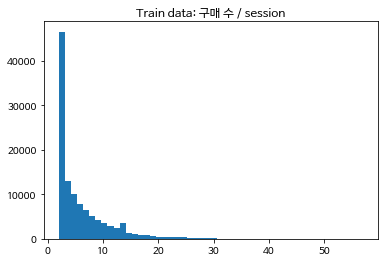

In [60]:
plt.hist(Train_session, 50)
plt.title(u'Train data: 구매 수 / session')
plt.show()

In [11]:
Train_session.agg(['min','max','mean'])

min      2.000000
max     57.000000
mean     5.970238
dtype: float64

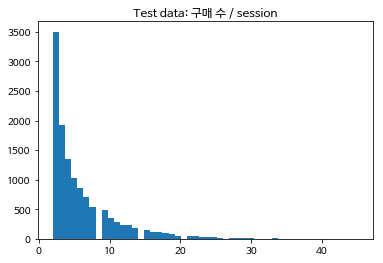

In [61]:
plt.hist(Test_session, 50)
plt.title(u'Test data: 구매 수 / session')
plt.show()

In [13]:
Train_session.agg(['min','max','mean'])

min      2.000000
max     57.000000
mean     5.970238
dtype: float64

In [14]:
Test_session.agg(['min','max','mean'])

min      2.000000
max     45.000000
mean     5.966389
dtype: float64

---

# 2. Doc2Vec

In [15]:
len(train_label.columns)

2266

해당 데이터의 column은 2266개의 label을 가지고 있습니다. 2266개의 상품이 거래됐다는 뜻입니다.
이 데이터를 input으로 그냥 넣기에는 고전적 deep learning 방식이며 one-hot 방식을 취하므로 "사과" 라는 데이터를 구매한 특징을 잘 살리지 못할 수 있습니다.  

이러한 이유로 해당 데이터를 Gensim의 Doc2Vec기술[[2]](https://arxiv.org/abs/1405.4053)   로 Embedding을 제안해 볼 수 있습니다. Hinton 교수님이 설명한 Deep learning에서 분산표현의 의미를 살리자는 것입니다.   
NLP 계열에서 사용하는 Doc2Vec을 상품에 적용한 Item2Vec 이라고 말하고 싶습니다.

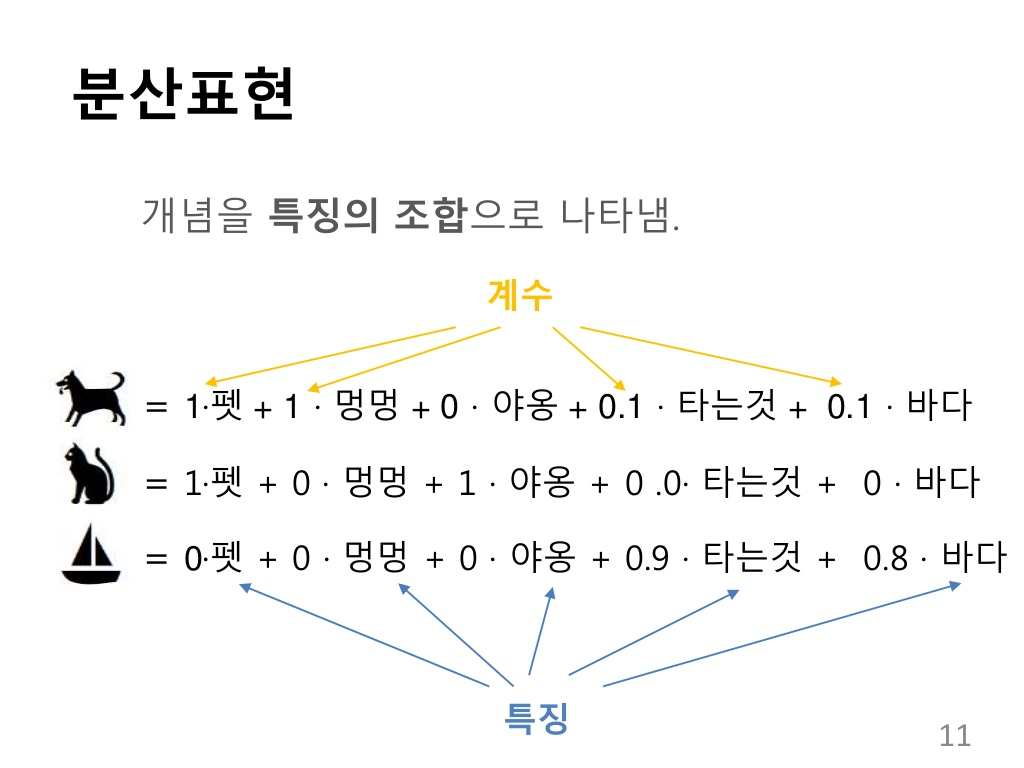

In [16]:
from IPython.display import Image
Image('images/분산표현2.png')

In [17]:
train_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in train_data.iterrows()]
test_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in test_data.iterrows()]

In [18]:
train_docs[0]

(['B610102/FAST_FOOD', 'B620202/피자'], 7473)

위 list는 `ID:7473` 인 고객이 한 번 결제할 때 구매한 내역입니다.

In [19]:
from gensim.models import doc2vec
from collections import namedtuple
import multiprocessing

In [20]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

cores = multiprocessing.cpu_count()

해당 Parameters는 [Rakuten [1]](https://www.slideshare.net/rakutentech/recommender-system-with-distributed-representation) 에서 실험한 Doc2Vec을 이용한 상품추천 시스템에 적용한 최적의 결과를 적용하였습니다.

In [16]:
if False:
    doc_vectorizer = doc2vec.Doc2Vec(
    
    dm = 0,            # PV-DBOW
    dbow_words = 0,    # w2v simultaneous with DBOW d2v / default 0
    window = 8,        # distance between the predicted word and context words 
    size = 300,        # vector size 
    alpha = 0.025,     # learning-rate
    min_alpha = 0.025, # min learning-rate
    
    seed = 1,
    
    sample= 1e-5,      # threshold for configuring
    min_count=3,       # ignore with freq lower
    workers=cores,     # multi cpu
    hs = 1             # hierarchical softmax / default 0
    )

    doc_vectorizer.build_vocab(tagged_train_docs)
    print(str(doc_vectorizer))

Doc2Vec(dbow,d300,n5,hs,mc3,s1e-05,t16)


In [17]:
if False:
    for epoch in range(20):
    %time doc_vectorizer.train(tagged_train_docs)
    doc_vectorizer.alpha -= 0.001
    doc_vectorizer.min_alpha = doc_vectorizer.alpha

CPU times: user 27.9 s, sys: 3.12 s, total: 31 s
Wall time: 24 s
CPU times: user 28 s, sys: 3.34 s, total: 31.4 s
Wall time: 24.2 s
CPU times: user 28.3 s, sys: 3.3 s, total: 31.6 s
Wall time: 24.4 s
CPU times: user 28.1 s, sys: 3.4 s, total: 31.5 s
Wall time: 24.3 s
CPU times: user 28.1 s, sys: 3.31 s, total: 31.4 s
Wall time: 24.2 s
CPU times: user 28 s, sys: 3.46 s, total: 31.5 s
Wall time: 24.3 s
CPU times: user 28.2 s, sys: 3.48 s, total: 31.7 s
Wall time: 24.5 s
CPU times: user 28.5 s, sys: 3.51 s, total: 32 s
Wall time: 24.7 s
CPU times: user 27.6 s, sys: 3.23 s, total: 30.8 s
Wall time: 23.8 s
CPU times: user 29 s, sys: 3.39 s, total: 32.4 s
Wall time: 25 s
CPU times: user 27.7 s, sys: 3.05 s, total: 30.7 s
Wall time: 23.8 s
CPU times: user 27.5 s, sys: 3.26 s, total: 30.7 s
Wall time: 23.8 s
CPU times: user 27.8 s, sys: 3.08 s, total: 30.9 s
Wall time: 23.9 s
CPU times: user 28.1 s, sys: 3.52 s, total: 31.6 s
Wall time: 24.4 s
CPU times: user 28.1 s, sys: 3.35 s, total: 31.4 s

In [18]:
# To save
doc_vectorizer.save('./Doc_model/D2V_WND.model')

In [21]:
# To load
doc_vectorizer=doc2vec.Doc2Vec.load('./Doc_model/D2V_WND.model')

Train 데이터를 이용해서 고객별 session 을 Doc2Vec 을 이용해서 학습하였습니다.  
2266개의 Item을 300 차원으로 Embedding 을 진행하여 각 column이 Items 의 특징을 가지게 되었습니다.

In [22]:
train_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]

In [23]:
train_item_pd = pd.DataFrame(train_item)
train_item_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.175875,0.050734,0.296223,0.117828,-0.160656,0.156266,-0.133493,-0.214674,-0.205308,0.077506,...,-0.230271,-0.186166,-0.318097,0.127994,-0.116879,0.251906,0.510883,0.306144,0.017437,0.153420
1,-0.129127,-0.030639,0.169386,0.170035,0.232563,-0.020522,0.031558,0.161347,0.081868,0.163581,...,-0.200750,0.056840,0.048734,-0.208358,-0.178706,-0.127398,0.023481,-0.104483,0.148916,-0.002975
2,0.078546,0.061433,0.256175,0.212319,0.087957,-0.157241,0.057371,-0.013836,-0.009655,0.092087,...,-0.107305,-0.011472,-0.045192,0.049259,-0.058725,-0.060460,0.110240,0.163316,-0.001388,-0.061461
3,0.047226,0.429295,0.273046,0.264711,0.020026,-0.008520,-0.380863,0.182935,0.046778,0.307562,...,-0.297329,-0.100919,-0.163673,0.019656,0.049018,-0.263425,0.484752,0.242064,-0.239053,-0.067336
4,0.034776,0.030256,0.208419,0.080748,-0.289359,0.050520,-0.129854,-0.106762,-0.102888,-0.061810,...,-0.130976,-0.215288,-0.249830,0.032149,-0.124171,0.277337,0.541305,0.159472,-0.008152,-0.018934


---

# 3. Wide & Deep learning

Google 의 Wide&Deep Model[[3]](https://arxiv.org/abs/1606.07792) 은 추천시스템을 위해 태어났다고 해도 생각해도 좋습니다.  간단한 예를 들어보겠습니다.  

* 날개가 달린 동물은 날 수 있다.  

Deep Learning을 이용해서 다음을 학습할 수 있습니다. 이것을 일반화(generalization) 라고 말할 수 있습니다. 하지만, 이는 모든 상황에 적용되지 않기 때문에 문제가 있습니다.

* 팽귄은 날개가 있다. 하지만..

우리는 이렇게 특별한 경우를 모형은 기억해야 합니다. 이것은 Wide Linear 모형으로 문제를 해결할 수 있고, 기억(memorization) 이라고 말합니다.

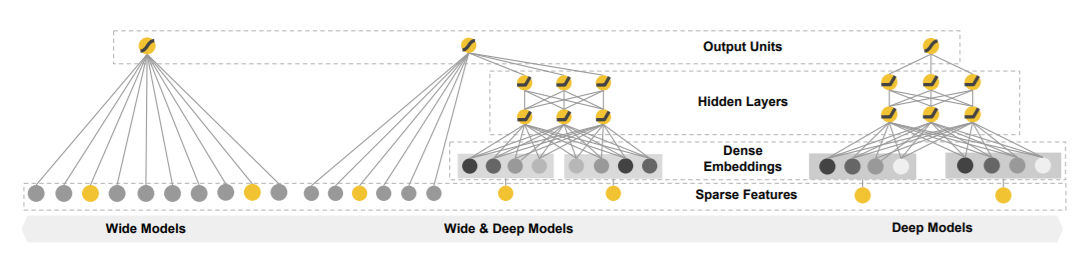

In [24]:
Image('images/wide_n_deep.png')

### Define Base Feature Columns

In [25]:
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib.learn import preprocessing
from datetime import datetime

Wide & Deep 모형은 다른 모형과 다른점이 있습니다. 바로 입력 데이터가 2개라는 것입니다. Wide Linear 에는 입력 데이터들의 교호작용을 적용해서 넣고, Deep learning 에는 일반적인 입력 데이터를 넣습니다.  그래서 두 모형에 들어갈 입력 데이터를 각각 정의해야 합니다.

고객 특징인 데이터들을 합치고 더미화 합니다.

In [26]:
user_feature = pd.DataFrame(pd.concat([categorical_data, continuous_data], axis=1, join_axes=[categorical_data.index]))
user_feature_dm = pd.get_dummies(user_feature)

In [27]:
user_feature_dm.head()

,다둥이,더영,롭스,하이마트,A_MOBILE/APP,B_MOBILE/APP,B_ONLINEMALL,C_MOBILE/APP,C_ONLINEMALL,D_MOBILE/APP,...,A거주지역_A630,A거주지역_A65,A거주지역_A69,A거주지역_A72,A거주지역_A75,A거주지역_A79,A거주지역_A82,A거주지역_A85,A거주지역_A87,A거주지역_ANA
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


Deep learningn 부분에 input할 데이터가 만들어 졌습니다.

In [28]:
Deep_data = pd.DataFrame(pd.concat([train_item_pd, user_feature_dm], axis=1, join_axes=[train_item_pd.index]))

### Cross columns

Wide 부분에 들어갈 Cross_culumns 들을 만드는 부분입니다.

In [29]:
def cross_columns(data, cross_colnames):
    for i in cross_colnames:
        tmp = 0
        for j in i:
            tmp += 1
            if tmp == 1:
                cross_data = data[j]
                columns = j
            else:
                cross_data = cross_data + data[j]
                columns = columns + "+" + j
        data[columns] = cross_data
        
    return data

In [30]:
CROSS_COLUMNS = [["성별", "연령대"],
                 ["다둥이", "더영", "롭스", "하이마트"]]

In [31]:
user_feature_cc = pd.get_dummies(cross_columns(user_feature, CROSS_COLUMNS))
user_feature_cc.head()

,다둥이,더영,롭스,하이마트,A_MOBILE/APP,B_MOBILE/APP,B_ONLINEMALL,C_MOBILE/APP,C_ONLINEMALL,D_MOBILE/APP,...,성별+연령대_M19세이하,성별+연령대_M20세~24세,성별+연령대_M25세~29세,성별+연령대_M30세~34세,성별+연령대_M35세~39세,성별+연령대_M40세~44세,성별+연령대_M45세~49세,성별+연령대_M50세~54세,성별+연령대_M55세~59세,성별+연령대_M60세이상
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Item Embedding matrix와 User features matrix 를 merge 합니다.

In [32]:
Wide_data = pd.DataFrame(pd.concat([train_item_pd, user_feature_cc], axis=1, join_axes=[train_item_pd.index]))

In [33]:
print(len(Deep_data.columns))
print(len(Wide_data.columns))

373
394


---

### Tensorflow Graphs

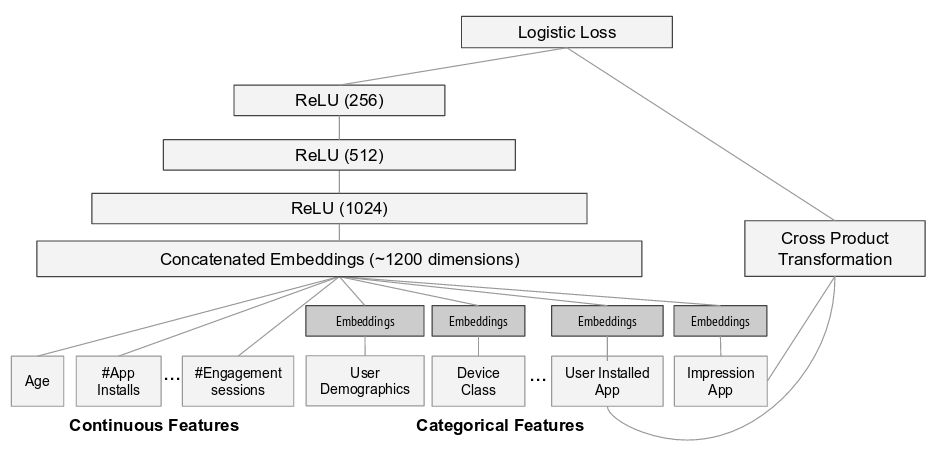

In [34]:
Image('images/WND structure.png')

In [35]:
# parameters
keep_prob = 0.5
learning_rate = 1e-5
training_epochs = 10001
batch_size = 128

wide_size = len(Wide_data.columns)
deep_size = len(Deep_data.columns)
output_size = len(train_label.columns)

He = tf.contrib.layers.variance_scaling_initializer()

# input place holders
tf.reset_default_graph()
Wide = tf.placeholder(tf.float32, [None, wide_size])
Deep = tf.placeholder(tf.float32, [None, deep_size])
Y = tf.placeholder(tf.float32, [None, output_size])
train_mode = tf.placeholder(tf.bool, name='train_mode')

### Wide

In [36]:
A = tf.get_variable("A", shape=[wide_size, output_size])
b = tf.Variable(tf.random_normal([output_size]))

wide = tf.add(tf.matmul(Wide, A), b)

### Deep

In [37]:
W1 = tf.get_variable("W1", shape=[deep_size, 1024], initializer=He)
b1 = tf.Variable(tf.random_normal([1024]))
L1 = tf.nn.relu(tf.matmul(Deep, W1) + b1)

W2 = tf.get_variable("W2", shape=[1024, 512], initializer=He)
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[512, 256], initializer=He)
b3 = tf.Variable(tf.random_normal([256]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[256, output_size], initializer=He)
b4 = tf.Variable(tf.random_normal([output_size]))

deep = tf.add(tf.matmul(L3, W4), b4)

In [38]:
hypothesis = wide + deep

In [39]:
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Session

In [40]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

### saver

In [41]:
import os
save_dir = 'W&D-checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'Lpoint_W&D')
saver = tf.train.Saver()

In [42]:
try:
    print("가장 최근 체크포인트를 로드합니다.")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
    
except:
    print("체크포인트가 없습니다. 변수를 초기화 합니다.")
    session.run(tf.global_variables_initializer())

가장 최근 체크포인트를 로드합니다.
INFO:tensorflow:Restoring parameters from W&D-checkpoints/Lpoint_W&D-10000
Restored checkpoint from: W&D-checkpoints/Lpoint_W&D-10000


10000번 학습합니다.

In [39]:
if False:
    for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(Deep_data) / batch_size)

    for i in range(0, len(Deep_data), batch_size):
        batch_wide = Wide_data[i:i+batch_size]
        batch_deep = Deep_data[i:i+batch_size]
        batch_label = train_label[i:i+batch_size]

        feed_dict_train = {Wide: batch_wide, Deep: batch_deep, Y: batch_label}
        opt, c = sess.run([optimizer, cost], feed_dict=feed_dict_train)

        avg_cost += c/total_batch

    if epoch % 500 == 0:
        time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("[Epoch: {:>4}][Cost: {:>.5f}][{}]".format(epoch, avg_cost, time))

    print('Learning Finished!')
    saver.save(sess, save_path=save_path, global_step=training_epochs)

[Epoch:    0][Cost: 0.56454][2017-08-14 14:08:16]
[Epoch:  500][Cost: 0.01090][2017-08-14 15:13:21]
[Epoch: 1000][Cost: 0.00996][2017-08-14 16:17:53]
[Epoch: 1500][Cost: 0.00933][2017-08-14 17:22:26]
[Epoch: 2000][Cost: 0.00885][2017-08-14 18:26:58]
[Epoch: 2500][Cost: 0.00847][2017-08-14 19:31:29]
[Epoch: 3000][Cost: 0.00816][2017-08-14 20:35:59]
[Epoch: 3500][Cost: 0.00789][2017-08-14 21:40:30]
[Epoch: 4000][Cost: 0.00766][2017-08-14 22:45:02]
[Epoch: 4500][Cost: 0.00746][2017-08-14 23:49:32]
[Epoch: 5000][Cost: 0.00728][2017-08-15 00:54:01]
[Epoch: 5500][Cost: 0.00712][2017-08-15 01:58:59]
[Epoch: 6000][Cost: 0.00698][2017-08-15 03:03:45]
[Epoch: 6500][Cost: 0.00685][2017-08-15 04:08:05]
[Epoch: 7000][Cost: 0.00673][2017-08-15 05:12:24]
[Epoch: 7500][Cost: 0.00662][2017-08-15 06:16:43]
[Epoch: 8000][Cost: 0.00652][2017-08-15 07:21:01]
[Epoch: 8500][Cost: 0.00642][2017-08-15 08:25:19]
[Epoch: 9000][Cost: 0.00633][2017-08-15 09:29:36]
[Epoch: 9500][Cost: 0.00625][2017-08-15 10:34:00]


---

# 4. Recommendation


단순한 Accuracy를 확인하면 다음과 같습니다.

In [43]:
test_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_item_pd = pd.DataFrame(test_item)

In [44]:
user_feature_dm_test = user_feature_dm[113265:].reset_index(drop=True)
user_feature_cc_test = user_feature_cc[113265:].reset_index(drop=True)

In [45]:
deep_data_test = pd.DataFrame(pd.concat([test_item_pd, user_feature_dm_test], axis=1, join_axes=[test_item_pd.index]))
Wide_data_test = pd.DataFrame(pd.concat([test_item_pd, user_feature_cc_test], axis=1, join_axes=[test_item_pd.index]))

In [46]:
YY = tf.equal(Y , 1)
XX = tf.greater(tf.sigmoid(hypothesis),0.5)
correct = tf.equal(XX, YY)
# score = sess.run(correct, feed_dict={Wide: Wide_data_test, Deep: deep_data_test, Y: test_label_real})
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
print("Accuracy: {:>.5f}".format(sess.run(accuracy, feed_dict={Wide: Wide_data_test, Deep: deep_data_test, Y: test_label_real})))

Accuracy: 0.98859


정확도가 98.848 % 정도가 나옵니다. scroe 값이 0.5 이상인 것만 추천을 해주는 방식인데  
실제 구매 개수는 min, avg, max=[2, 6, 45] 의 분포를 갖고  
추천 개수는 min, avg, max=[0, 5, 41] 값이 나왔습니다.  
매번 20개정도 틀린값이 나온다고 해도 2246 / 2266 = 0.991 가 나오기 때문에 이는 정확한 평가가 아닙니다.

추천시스템은 일반적인 Accuracy를 이용하지 않습니다. 2266개나 되는 Label을 맞출 리 없죠.   
보통은 Top 3 내지 Top 20을 추천을 하게 됩니다.   
그중 실제로 고객이 구매한 내역과 비교하여 Hit rate: (맞춘 개수 / 추천한 개수) 를 보게 됩니다.   
Hit rate 는 통계학에서 Precision (정밀도) 라는 용어로 사용되고 있습니다.

#### Precision = tp / (tp + fp)
""    | Recommended | Not Recommended | Total
:-----|:-----------:|:--------------:|:--------
bought| tp | fn | ""
not bought | fp | tn | ""
Total | Top10 | 2256 | 2266

In [47]:
score = sess.run(tf.sigmoid(hypothesis), feed_dict={Wide: Wide_data_test, Deep: deep_data_test})
score = pd.DataFrame(score, columns=train_label.columns)

9175번 고객과 2666번 고객을 예를 들면 위 모델로 추천을 해준 아이템 10개는 다음과 같으며  
실제 고객이 구매한 아이템은 그 밑에 나타냈습니다.

### ID: 9175
* 추천 상품 

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'B210801/음식물봉투'|'B870503/접착제'  |'B870301/멀티탭'
'B320201/유아토들러내의'|'B260701/보드게임'  |'B250502/유아서적'
'B260903/조립/프라모델'|'B200801/다이소'|'B680403/여성면덧신'
'B680301/아동캐주얼'| ''                |''

* 실제 마지막 구매 상품  

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'B190102/칫솔'      |'B660402/성인스킨케어'|'B660501/베이비스킨케어'|

### ID: 2666
* 추천 상품 

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'B720101/보리류'|'B630402/일반간식류행사'|'B110902/요리식초'
'B110201/케찹'|'B130501/믹스커피'|'B130205/식수용차'
'B800201/국물용멸치'|'B141505/한과'|'B720104/찰현미류'
'B111101/설탕'|''  |''

* 실제 마지막 구매 상품  

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'B110604/부침/튀김가루'|'B110902/요리식초'|''|

추천 아이템을 살펴보면, 실제 구매한 아이템과 어느정도 일치성이 있음을 알 수 있습니다. 

In [48]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        for j in range(len(top)):
            if top[j] in test_matix["item"][i].split():
                tmp += 1

        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)

    return avg_acc

In [50]:
print("Hit rate of Top 3: {:>.5f}".format(get_acc(score, 3, test_label)))
print("Hit rate of Top 10: {:>.5f}".format(get_acc(score, 10, test_label)))

Hit rate of Top 3: 0.02993
Hit rate of Top 10: 0.02758


10개를 추천해준다면 그 중 2.8% 가량을 실제로 구매하는 것으로 나타났습니다.    

---

# 5. 결론

다시 한번 말하지만, 추천시스템은 정확도로 판단을 하는 모형이 아닙니다. 2%의 예측력이 갖는 의미가 이해되지 않는다면 당신이 11번가나 쿠팡에 들어갔을 때 홈페이지 첫 Index화면에 추천받았던 상품 중에 실제로 구매를 얼만큼 했나 생각해 보시면 2%가 갖는 의미를 파악하실 수 있을 것입니다.  
(사실 대 분류 측면으로 정확도를 측정하면 정확도가 높게 나올 수 있을 것입니다.)

상춤 추천은 추천 이후에 또다른 처리작업이 필요할 것입니다.
예를들어 넷플릭스가 한 번 본 영화를 다시 추천해주지 않는다거나, 아마존이 미성년자에게 성인상품을 추천해주지 않는다는 특별한 처리과정이 필요할 수 있습니다.  

위 분석에서는 한달 전 고가의 가전제품(냉장고, 세탁기)을 구매한 고객에게 재 구매를 요구하지 않는다거나, 생활필수품 중 재 구매율이 높은(종량제 봉투)를 추천해 주지 않는 작업이 필요할 것입니다.

위 추천방식에서 사용한 방법 말고 다른 방법들도 다수 존재합니다. 예를 들어 온라인 쇼핑몰 검색창에 Query:"사과"를 검색했을 때 사과와 같이 다른 상품들을 추천해줄 수 도 있습니다. 


---

# Reference

### [[1] Recommender System with Distributed Representation](https://www.slideshare.net/rakutentech/recommender-system-with-distributed-representation)   
### [[2] Distributed Representations of Sentences and Documents](https://arxiv.org/abs/1405.4053)   
### [[3] Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792)   
### [[4] TensorFlow Wide & Deep Learning Tutorial](https://www.tensorflow.org/tutorials/wide_and_deep)   
### [[5] Korean NLP in Python](http://konlpy.org/en/v0.4.4/)